# Decision making under uncertainty

In this lecture, you learned about how the Markov decision process (MDP) framework can be extended to allow uncertainty about the states. This can be used to model a wide range of decision-making problems where there is uncertainty or noise associated with the state of the world.

We considered the example of the random dot motion discrimination task, where a subject must indicate the direction in which the majority of dots are moving. In this assignment, you will solve a two-stage formulation of this task, where the decision-maker can either make an immediate decision (i.e., at the first stage) on the basis of initial information, or choose to wait and gather further information before making their choice (i.e., at the second stage). The complete description of the problem can be found in the lecture slides and also in the original paper: http://www.gatsby.ucl.ac.uk/~dayan/papers/NDM002wc.pdf

Your task is to reproduce the plots from Figure 9 of the paper, interpret the results, and explain the steps of the solution.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

## 0. Define the parameters of the model (0.5 pts)

In [13]:
# INSERT CODE HERE
rew = {0: {0: 1, 1: 0, 2: -0.1}, 1: {0: 0, 1: 1, 2: -0.1}, 2: {0: 1, 1: 0}, 3: {0: 0, 1: 1}}
p_alpha = p_beta = np.array([0.5, 0.5])
c_alpha = c_beta = np.linspace(0, 10, 1000)
mu, sigma = np.array([6, 4]), 1

In [14]:
def gaussian(mu, sigma, x_range=[0, 10], num_samples=1000):
    c_beta = np.linspace(x_range[0], x_range[1], num_samples)
    gauss = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(c_beta - mu)**2 / (2 * sigma**2))
    return gauss, c_beta

alpha_ob = [gaussian(m, sigma)[0] for m in mu]
beta_ob = [gaussian(m, sigma)[0] for m in mu]

## 1. Updating the belief state  (2.5 pts)
The actual direction of motion ('state') is not completely observable to the subject. Hence, the subject can only rely on observations to compute the *belief* that the direction of motion is left or right (this is the posterior probability or 'belief state'). 

### 1a. Write a function that will calculate this posterior given the prior belief and an observation (the belief update). (0.5 pt)

In [15]:
# INSERT CODE BELOW
def calculate_post_b(observation, prior):
    ob1, ob2 = observation
    post1 = (prior[0]*ob1)/((prior[0]*ob1)+(prior[1]*ob2))
    post2 = (prior[1]*ob2)/((prior[0]*ob1)+(prior[1]*ob2))
    return post1, post2

### 1b. Use this function to update the belief on the first observation at step $\beta$ and reproduce Fig 9A.  Interpret the plot. (1 pt)

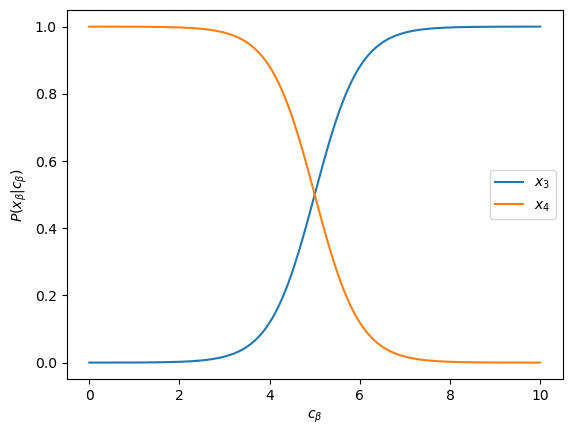

In [16]:
# INSERT CODE BELOW
post_x3, post_x4 = calculate_post_b(beta_ob, p_beta)
plt.plot(c_beta, post_x3, label = r'$x_3$')
plt.plot(c_beta, post_x4, label = r'$x_4$')
plt.xlabel(r'$c_\beta$')
plt.ylabel(r'$P(x_\beta|c_\beta)$')
plt.legend()

$c_\beta$ being below 5 increase belief in x4, while values above 5 favor x3. This is due to the means being different (4 and 6). The closer the value is to 5, the higher the uncertainty in which state one is.

### 1c. Write a function to update the belief on observing another sample at step $\alpha$ and reproduce Fig 9B.  Interpret the plot. (1 pt)
Hint: You will have to calculate this probability for every possible pair of observations.

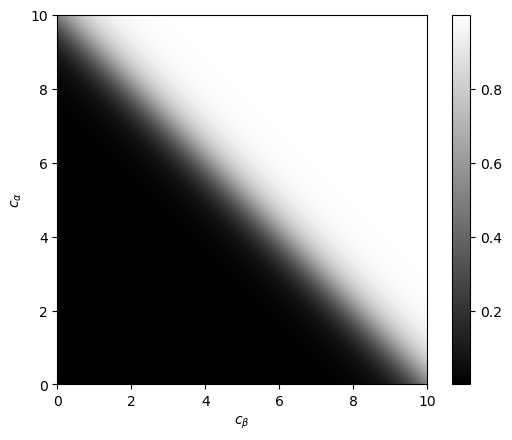

In [17]:
# INSERT CODE BELOW
def update_a(observation, p1, p2): 
    ob1, ob2 = observation
    p11 = ob1[:, None] * p1
    p22 = ob2[:, None] * p2
    p112 = p11 / (p11 + p22)
    p221 = p22 / (p11 + p22)
    return p112, p221

prob_x1, prob_x2 = update_a(alpha_ob, post_x3, post_x4)

fig, ax = plt.subplots()
img = ax.imshow(prob_x1, cmap = 'gray', extent=[0, 10, 10, 0])
ax.invert_yaxis()
ax.set_xlabel(r'$c_\beta$')
ax.set_ylabel(r'$c_\alpha$')
plt.colorbar(img, ax=ax)
plt.show()

In this plot, one can see the posterior P(x1/calpha, cbeta). Being in x1 can only happen if before in x3, which is why at high $c_\beta$ and $c_\alpha$ values the posterior is high. As already seen above, the highest uncertainty is at the diagonal.

## 2. Solving for the optimal actions (7 pts)
Now that we have a way to update the belief states, we can use them to determine the best course of action at each of the steps (the 'optimal policy'). 

### 2a. When finding the optimal policy, why does it make sense to calculate the best action at the final stage $\alpha$, and work backwards? (1 pt)

Working backwards is efficent because of the Markow propterty: future states depend only on the current state and action. Therfore one only needs to consider the immediate consequences of each action not knowing the entire history of steps taken, enabling to split up the problem in more smaller problems.

### 2b. Write a function that will calculate the value of the best action at $\alpha$ and reproduce Fig 9C. Explain what the plot shows. (1 pt)

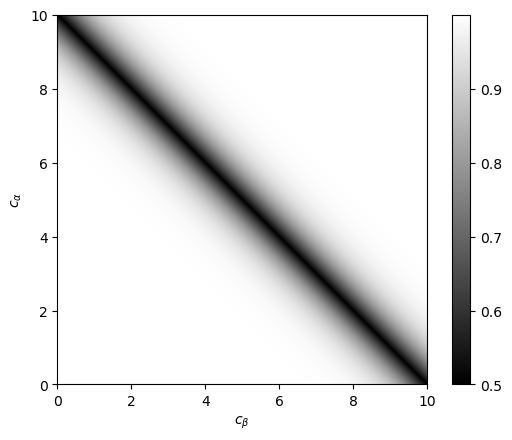

In [18]:
# INSERT CODE BELOW
def best_action_alpha(p1, p2, rew): 
    q = np.maximum(p1 * rew[0][0], p2 * rew[1][1])
    return q

q = best_action_alpha(prob_x1, prob_x2, rew)

fig, ax = plt.subplots()
img = ax.imshow(q, cmap = 'gray', extent=[0, 10, 10, 0])
ax.invert_yaxis()
ax.set_xlabel(r'$c_\beta$')
ax.set_ylabel(r'$c_\alpha$')
plt.colorbar(img, ax=ax)
plt.show()

Inm this plot, one can see the Q values for different cues. As above the highest uncertainty is in the diagonal, where the optimal decision cannot be found and thus the reward is chosen randomly resulting in a q value of 0.5 as only half of the times the reward is collected. Not on the diagonal the q values goes quickly to 1, as it is now clear in which state one is and which option is to pick for the reward. 

### 2c. Before finding the best action at $\beta$, we have one more step to do. We need the values of the best actions at $\alpha$ that we just calculated and the probability of observing $c_{\alpha}$ given $c_{\beta}$ ($P(c_{\alpha} | c_{\beta})$). Why? (1 pt)

The caluclation of best asctions at $\alpha$ is necessary, because first C is chosen at beta and then observe the cue c_alpha. $P(c_{\alpha} | c_{\beta})$ has to be calculated becuase the belief state at $\alpha$ is updated based on this (the observed cues).

### 2d. Write a function that will calculate $P(c_{\alpha} | c_{\beta})$ and reproduce Fig 9D. Explain how you calculated this probability and what the plot shows. (1 pt)
Hint: You will have to marginalise the posteriors over the possible states.

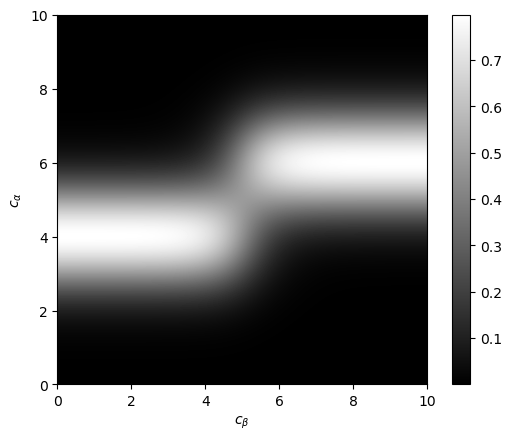

In [19]:
def calculate_prob(a_ob, b_ob):
    prob = (a_ob[0][:, None] * b_ob[0] + a_ob[1][:, None] * b_ob[1]) / (0.5 * (b_ob[0] + b_ob[1]))
    return prob

prob = calculate_prob(alpha_ob, beta_ob)
fig, ax = plt.subplots()
img = ax.imshow(prob, cmap = 'gray', extent=[0, 10, 10, 0])
ax.invert_yaxis()
ax.set_xlabel(r'$c_\beta$')
ax.set_ylabel(r'$c_\alpha$')
plt.colorbar(img, ax=ax)
plt.show()

The probability was caluclated as a weighted combination of observation probabilites at states alpha and beta. This plot shows the probability of getting a calpha konwing the cbeta. This is plot is very similar to the first plot. Once again, the uncertainty is highest at c = 5. If cbeta is higher than 5, calpha = 6 and if it is lower calpha = 4. This is due to the two gaussian means being 4 and 6. 

### 2e. We are now ready to find the best action at $\beta$. Write a function that calculates the values associated with each of the actions and reproduce Fig 9E. What does the plot tell you about what the best action is at $\beta$? (1 pt)
Hint: For action C, you will have to numerically integrate over possible observations ${c_{\alpha}}$ using the step size ($dc_{\alpha}$) you defined on your Gaussian observation distribution. 

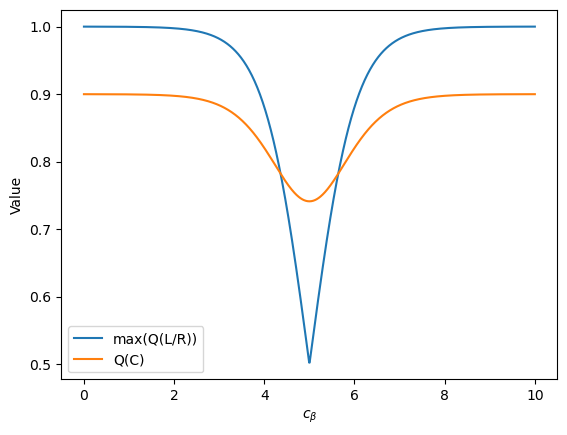

In [20]:
Q = np.zeros((3, 1000))
post_x3, post_x4 = calculate_post_b(beta_ob, p_beta)
Q[0] = post_x3 * rew[0][0]
Q[1] = post_x4 * rew[1][1]

int = lambda a, post1, post2: best_action_alpha(*update_a(alpha_ob, post1, post2), rew) * a
int_1 = int(alpha_ob[0], post_x3, post_x4)
int_2 = int(alpha_ob[1], post_x3, post_x4)

e1 = np.trapz(int_1, c_alpha, 0.001)
e2 = np.trapz(int_2, c_alpha, 0.001)

Q[2, :] = -0.1 + post_x3 * e1 + post_x4 * e2

maxi = np.max(Q[:2, :], axis=0)

plt.plot(c_beta, maxi, label='max(Q(L/R))')
plt.plot(c_beta, Q[2, :], label='Q(C)')
plt.legend()
plt.xlabel('$c_\\beta$')
plt.ylabel('Value')
plt.show()

This plot shows the average value and the two lines picking L or R and picking C. If the cbeta value is not close to 5, the uncertainty is low and thus the highest possible value is either picking L or R which will lead directly to the rewar. Picking would decrease the summed reward 0.9 and is thus not the favorable pick. Picking C is only favorable in the uncertain are araound cbeta being close to 5 as the average value in this region is higher when picking C than directly left or right.

### 2f. What will reduce (or increase) the range of observations at $\beta$ where it is best to choose to wait for another observation (choosing C)? Can you tweak a parameter to do this and produce a plot similar to Fig 9E to show this? (2 pts)
Hint: You will have to re-run the steps with this changed parameter. 

INSERT ANSWER BELOW